In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image

PATH = 'dataset/exp-data'
IMG_SIZE = 128
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 300
EPSILON = 0.00005
BATCH_SIZE = 64
LEARNING_RATE_DISC=0.00004
LEARNING_RATE_GEN=0.0004
BETA1 = 0.5
WEIGHT_INIT_STDDEV =0.02

# create numpy array (tensor) for the dataset
train_images = np.ndarray(shape=(6000, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, img in enumerate(os.listdir(PATH)):
    if i >= 6000:
        break
    # using keras image preprocessing package convert the images into a matrix
    image = load_img(PATH + '/' + img)
    x = img_to_array(image)
    
    # add the matrices into the tensor
    train_images[i] = x

train_images.shape

Using TensorFlow backend.


(6000, 128, 128, 3)

In [2]:
train_images = train_images/127.5 - 1 # normalize data to -1 to 1
len(train_images[0])

128

In [3]:
def Generator(Z,training):
    with tf.variable_scope('generator',reuse=not training):
        
        # z = tf.placeholder(tf.float32, (None, noise_dim))
        fully_connected = tf.layers.dense(Z, 8*8*1024)
        fully_connected = tf.layers.batch_normalization(fully_connected)
        fully_connected = tf.nn.leaky_relu(fully_connected)
        
        fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 1024))
        
        print(fully_connected.shape)
        
        
        # 8x8x1024 -> 16x16x512
        conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
                                           filters=512,
                                           kernel_size=[5,5],
                                           strides=[2,2],
                                           padding='SAME', 
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV), 
                                           name='g_conv1')
        batch1 = tf.layers.batch_normalization(inputs = conv1,
                                               training=training,
                                               epsilon=EPSILON, 
                                               name='g_batch1')
        A1 = tf.nn.leaky_relu(batch1, name='g_A1')
        
        print(A1.shape)
        
        
        # 16x16x512 -> 32x32x256
        conv2 = tf.layers.conv2d_transpose(inputs=A1,
                                           filters=256,
                                           kernel_size=[5,5],
                                           strides=[2,2],
                                           padding='SAME', 
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV), 
                                           name='g_conv2')
        batch2 = tf.layers.batch_normalization(inputs = conv2,
                                               training=training,
                                               epsilon=EPSILON, 
                                               name='g_batch2')
        A2 = tf.nn.leaky_relu(batch2, name='g_A2')
        
        print(A2.shape)
        
        # 32x32x256-> 64x64x128
        conv3 = tf.layers.conv2d_transpose(inputs=A2,
                                           filters=128,
                                           kernel_size=[5,5],
                                           strides=[2,2],
                                           padding='SAME', 
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV), 
                                           name='g_conv3')
        batch3 = tf.layers.batch_normalization(inputs = conv3,
                                               training=training,
                                               epsilon=EPSILON, 
                                               name='g_batch3')
        A3 = tf.nn.leaky_relu(batch3, name='g_A3')
        
        print(A3.shape)
        
        # 64x64x128 -> 128x128x64
        conv4 = tf.layers.conv2d_transpose(inputs=A3,
                                           filters=64,
                                           kernel_size=[5,5],
                                           strides=[2,2],
                                           padding='SAME', 
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV), 
                                           name='g_conv4')
        batch4 = tf.layers.batch_normalization(inputs = conv4,
                                               training=training,
                                               epsilon=EPSILON, 
                                               name='g_batch4')
        A4 = tf.nn.leaky_relu(batch4, name='g_A4')
        
        print(A4.shape)
        
        # 128x128x64 -> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs=A4,
                                            filters=3,
                                            kernel_size=[5,5],
                                            strides=[1,1],
                                            padding='SAME', 
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                            name='g_logits')
        out = tf.tanh(logits, name='out')
        return out

In [4]:
def Discriminator(X, reuse):
    with tf.variable_scope('discriminator', reuse=reuse): 
        
        # 128*128*3 -> 64x64x64 
        conv1 = tf.layers.conv2d(inputs=X,
                                 filters=32,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding='SAME', 
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='d_conv1')
        
        batch1 = tf.layers.batch_normalization(conv1,
                                               training=True,
                                               epsilon=EPSILON, 
                                               name='d_batch1')
        A1 = tf.nn.leaky_relu(batch1, name='d_A1')
        
        print(A1.shape)
        
        # 64x64x64-> 32x32x128 
        conv2 = tf.layers.conv2d(inputs=A1,
                                 filters=128,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding='SAME', 
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='d_conv2')
        batch2 = tf.layers.batch_normalization(conv2,
                                               training=True,
                                               epsilon=EPSILON, 
                                               name='d_batch2')
        A2 = tf.nn.leaky_relu(batch2, name='d_A2')
        
        print(A2.shape)
        
        # 32x32x128 -> 16x16x256  
        conv3 = tf.layers.conv2d(inputs=A2,
                                 filters=256,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding='SAME', 
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='d_conv3')
        batch3 = tf.layers.batch_normalization(conv3,
                                               training=True,
                                               epsilon=EPSILON, 
                                               name='d_batch3')
        A3 = tf.nn.leaky_relu(batch3, name='d_A3')
        
        print(A3.shape)
        
        # 16x16x256 -> 16x16x512
        conv4 = tf.layers.conv2d(inputs=A3,
                                 filters=512,
                                 kernel_size=[5,5],
                                 strides=[1,1],
                                 padding='SAME', 
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='d_conv4')
        batch4 = tf.layers.batch_normalization(conv4,
                                               training=True,
                                               epsilon=EPSILON, 
                                               name='d_batch4')
        A4 = tf.nn.leaky_relu(batch4, name='d_A4')
        
        print(A4.shape)
        
        # 16x16x512 -> 8x8x1024
        conv5 = tf.layers.conv2d(inputs=A4,
                                 filters=1024,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding='SAME', 
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='d_conv5')
        batch5 = tf.layers.batch_normalization(conv5,
                                               training=True,
                                               epsilon=EPSILON, 
                                               name='d_batch5')
        A5 = tf.nn.leaky_relu(batch5, name='d_A5')
        
        print(A5.shape)

        flatten = tf.reshape(A5, (-1, 8*8*1024))
        
        print(flatten.shape)
        logits = tf.layers.dense(inputs=flatten,
                                 units=1,
                                 activation=None)
        out = tf.sigmoid(logits)
        return out, logits

In [5]:
x = tf.placeholder(tf.float32, shape=(None, 128, 128, 3))
z = tf.placeholder(tf.float32, shape=(None, NOISE_DIM))

g_sample = Generator(z, True)
d_model_real, d_logits_real = Discriminator(x, reuse=False)
d_model_fake, d_logits_fake = Discriminator(g_sample, reuse=True)

real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
d_loss = tf.reduce_mean(real_loss+fake_loss)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
(?, 8, 8, 1024)
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
(?, 16, 16, 512)
(?, 32, 32, 256)
(?, 64, 64, 128)
(?, 128, 128, 64)
Instructions for updating:
Use keras.layers.conv2d instead.
(?, 64, 64, 32)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 8, 8, 1024)
(?, 65536)
(?, 64, 64, 32)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 8, 8, 1024)
(?, 65536)


In [6]:
print(g_sample.shape)
print(d_model_real, d_logits_real)
print(d_model_fake, d_logits_fake)
print(d_loss)
print(g_loss)

(?, 128, 128, 3)
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32) Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("discriminator_1/Sigmoid:0", shape=(?, 1), dtype=float32) Tensor("discriminator_1/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)


In [7]:
g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='generator')
d_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='discriminator')

g_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE_GEN, beta1=BETA1).minimize(g_loss,var_list = g_vars)
d_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE_DISC, beta1=BETA1).minimize(d_loss,var_list = d_vars)

In [21]:
d_losses = []
g_losses = []

def show_samples(sample_images, dim=(4,4), figsize=(8,8)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(sample_images):
        img = ((img+1.0)*127.5).astype('int')
        image = Image.fromarray(img, 'RGB')
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer()) 
#     z_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_DIM))
#     g_plot = sess.run(g_sample, feed_dict={z: z_batch})
#     show_samples(g_plot[:16])

def train(epochs, batch_size=64):
    # training of (6000,128,128,3)
    batch_count = train_images.shape[0]/batch_size
    print ('Epochs:', epochs)
    print ('Batch size:', batch_size)
    print ('Batches per epoch:', batch_count)
    
    with tf.Session() as sess:
        # initialize variables otherwise FailedPreconditionError
        sess.run(tf.global_variables_initializer()) 
        
        for e in range(1, epochs+1):

            for i in np.arange(batch_count):
                x_batch = train_images[int(i*batch_size):int((i+1)*batch_size)]
                z_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_DIM))
#                 print(x_batch.shape)
#                 print(z_batch.shape)
                
                _, dloss = sess.run([d_step, d_loss], feed_dict={x: x_batch , z: z_batch})   
                _, gloss = sess.run([g_step, g_loss], feed_dict={z: z_batch})

            print ("Epoch: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(e,dloss,gloss))

            if e == 1 or e % 5 == 0:
                z_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_DIM))
                g_plot = sess.run(g_sample, feed_dict={z: z_batch})
                show_samples(g_plot[:16])

            d_losses.append(dloss)
            g_losses.append(gloss)

Epochs: 300
Batch size: 16
Batches per epoch: 375.0
Epoch: 1	 Discriminator loss: 0.4228	 Generator loss: 4.7570


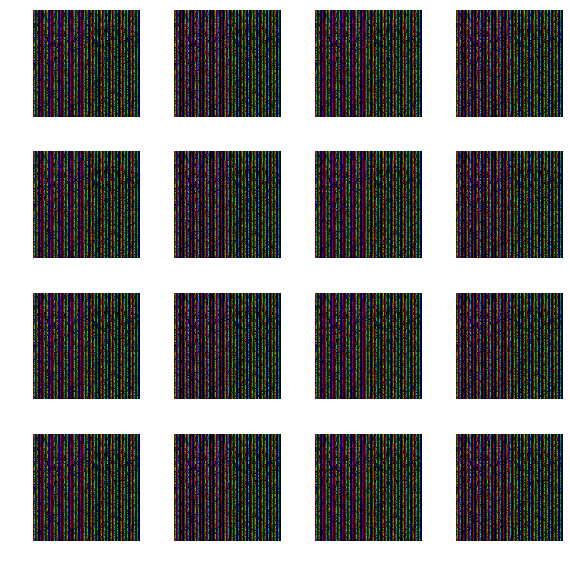

Epoch: 2	 Discriminator loss: 1.3808	 Generator loss: 1.0143
Epoch: 3	 Discriminator loss: 1.7391	 Generator loss: 0.8789
Epoch: 4	 Discriminator loss: 1.4959	 Generator loss: 0.7495
Epoch: 5	 Discriminator loss: 1.3965	 Generator loss: 0.7914


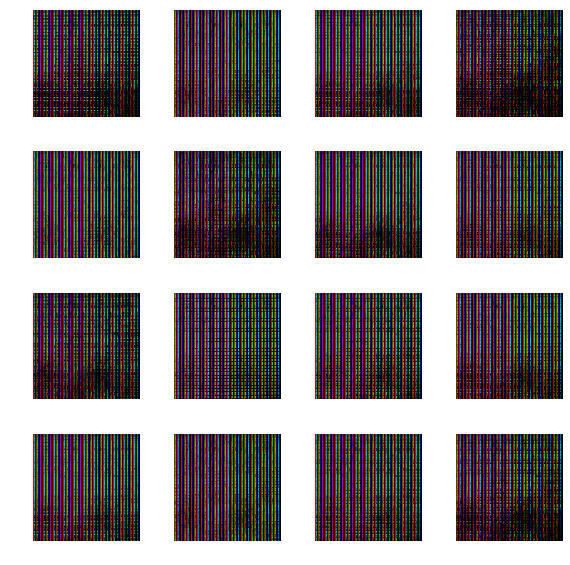

Epoch: 6	 Discriminator loss: 1.1918	 Generator loss: 0.9838
Epoch: 7	 Discriminator loss: 1.3179	 Generator loss: 0.9440
Epoch: 8	 Discriminator loss: 1.3771	 Generator loss: 0.7456
Epoch: 9	 Discriminator loss: 1.3346	 Generator loss: 0.9310
Epoch: 10	 Discriminator loss: 1.8692	 Generator loss: 1.1885


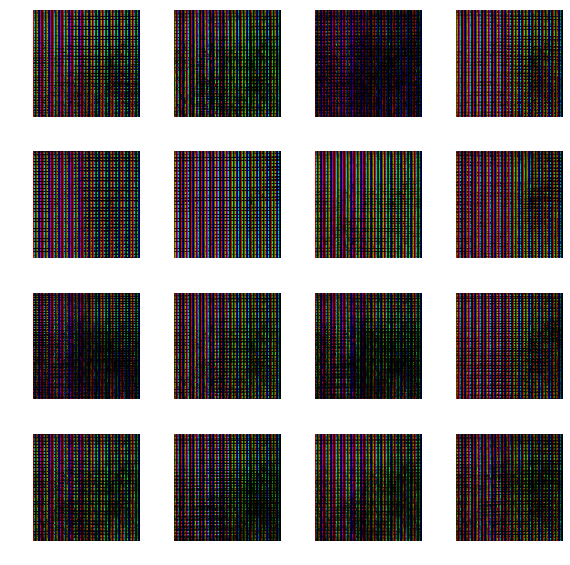

Epoch: 11	 Discriminator loss: 1.2592	 Generator loss: 1.0293
Epoch: 12	 Discriminator loss: 1.6585	 Generator loss: 0.9676
Epoch: 13	 Discriminator loss: 1.3140	 Generator loss: 0.7857
Epoch: 14	 Discriminator loss: 1.5398	 Generator loss: 1.0110
Epoch: 15	 Discriminator loss: 1.2937	 Generator loss: 1.0280


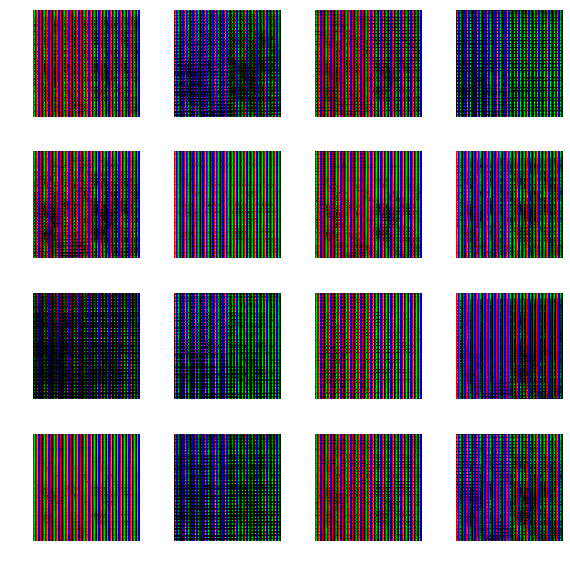

Epoch: 16	 Discriminator loss: 1.4176	 Generator loss: 0.9753
Epoch: 17	 Discriminator loss: 1.3724	 Generator loss: 1.0300
Epoch: 18	 Discriminator loss: 1.3889	 Generator loss: 0.9237
Epoch: 19	 Discriminator loss: 1.4034	 Generator loss: 0.8918
Epoch: 20	 Discriminator loss: 1.3885	 Generator loss: 1.1303


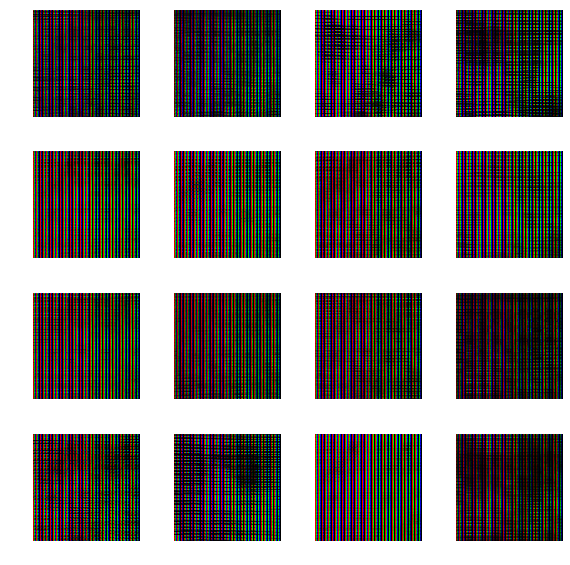

Epoch: 21	 Discriminator loss: 1.4994	 Generator loss: 1.0966
Epoch: 22	 Discriminator loss: 1.2711	 Generator loss: 1.0006
Epoch: 23	 Discriminator loss: 1.4482	 Generator loss: 0.9624
Epoch: 24	 Discriminator loss: 1.5232	 Generator loss: 0.7896
Epoch: 25	 Discriminator loss: 1.4520	 Generator loss: 1.0724


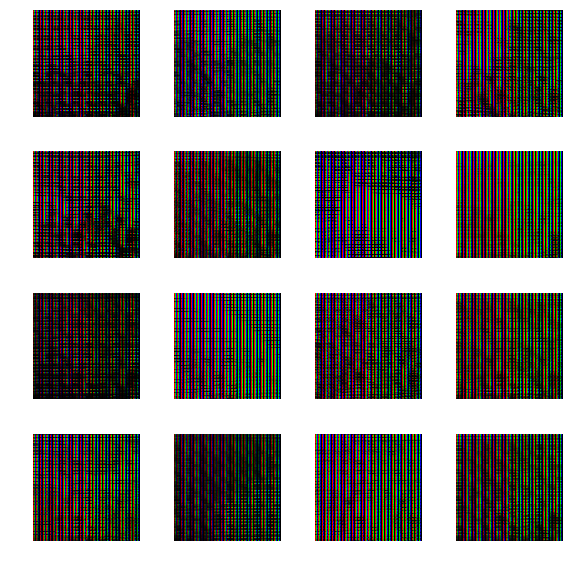

Epoch: 26	 Discriminator loss: 1.3802	 Generator loss: 1.1748
Epoch: 27	 Discriminator loss: 1.3482	 Generator loss: 1.5679
Epoch: 28	 Discriminator loss: 1.3113	 Generator loss: 1.7615
Epoch: 29	 Discriminator loss: 1.1041	 Generator loss: 1.5655
Epoch: 30	 Discriminator loss: 1.2857	 Generator loss: 1.5615


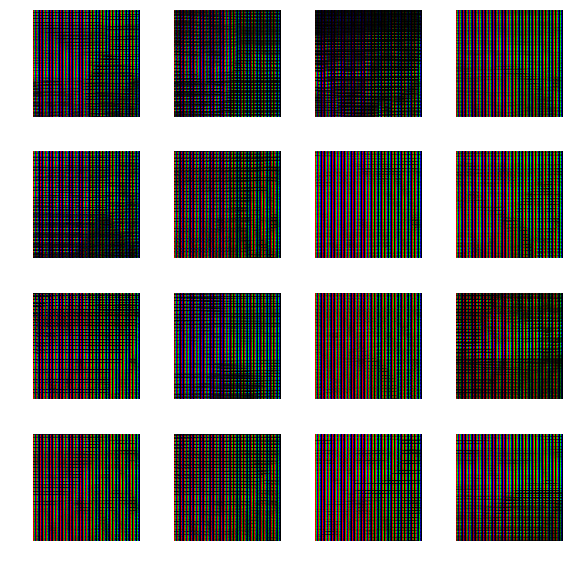

Epoch: 31	 Discriminator loss: 1.2618	 Generator loss: 1.6164
Epoch: 32	 Discriminator loss: 1.0700	 Generator loss: 1.2315
Epoch: 33	 Discriminator loss: 1.3424	 Generator loss: 1.1070
Epoch: 34	 Discriminator loss: 1.3257	 Generator loss: 1.5265
Epoch: 35	 Discriminator loss: 1.0484	 Generator loss: 1.1239


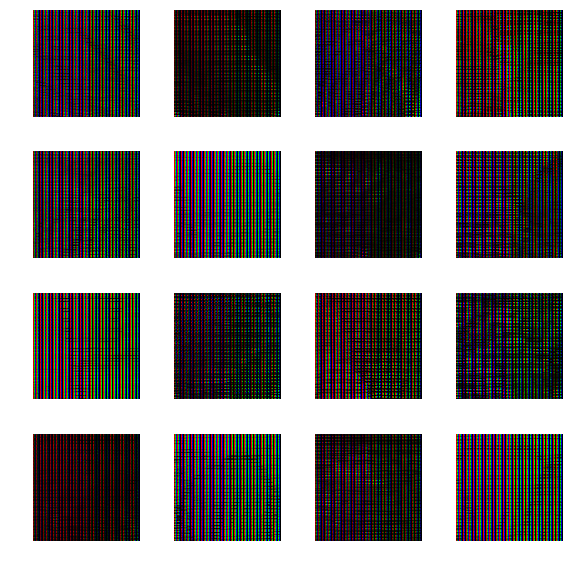

Epoch: 36	 Discriminator loss: 1.0091	 Generator loss: 1.3830
Epoch: 37	 Discriminator loss: 1.0325	 Generator loss: 1.6319
Epoch: 38	 Discriminator loss: 0.7253	 Generator loss: 1.8938
Epoch: 39	 Discriminator loss: 0.9138	 Generator loss: 1.4667
Epoch: 40	 Discriminator loss: 0.6307	 Generator loss: 2.5336


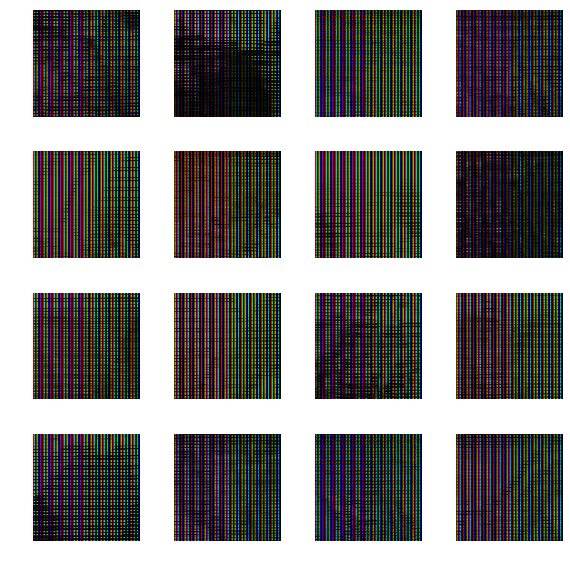

Epoch: 41	 Discriminator loss: 1.0431	 Generator loss: 3.0902
Epoch: 42	 Discriminator loss: 1.0749	 Generator loss: 2.5105
Epoch: 43	 Discriminator loss: 1.0159	 Generator loss: 1.3104
Epoch: 44	 Discriminator loss: 0.5028	 Generator loss: 2.9964
Epoch: 45	 Discriminator loss: 0.6276	 Generator loss: 1.7406


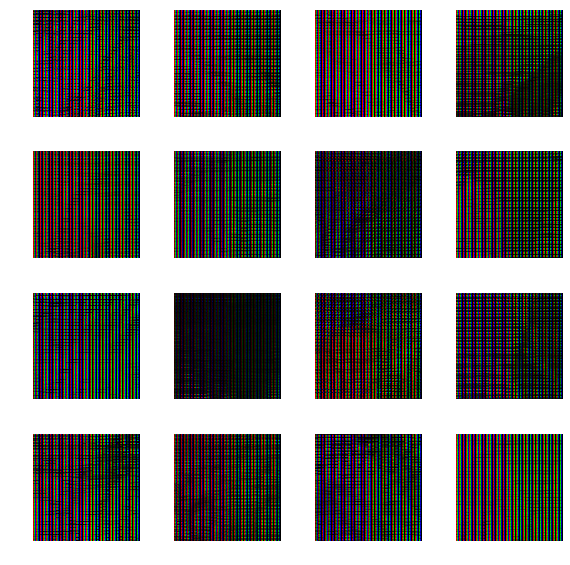

Epoch: 46	 Discriminator loss: 0.5103	 Generator loss: 2.2200
Epoch: 47	 Discriminator loss: 0.4897	 Generator loss: 2.5161
Epoch: 48	 Discriminator loss: 0.5949	 Generator loss: 1.7840
Epoch: 49	 Discriminator loss: 0.8938	 Generator loss: 4.0274
Epoch: 50	 Discriminator loss: 0.3679	 Generator loss: 3.1790


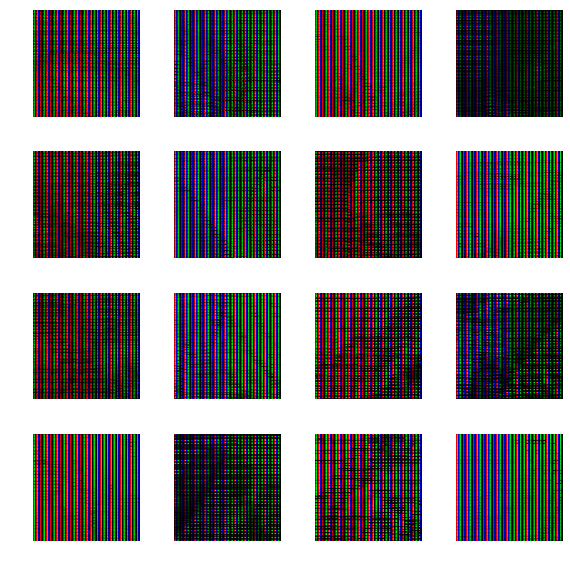

Epoch: 51	 Discriminator loss: 0.3888	 Generator loss: 3.8524
Epoch: 52	 Discriminator loss: 0.3868	 Generator loss: 5.1397
Epoch: 53	 Discriminator loss: 0.2786	 Generator loss: 3.6122
Epoch: 54	 Discriminator loss: 2.0340	 Generator loss: 0.4258
Epoch: 55	 Discriminator loss: 0.4893	 Generator loss: 5.8275


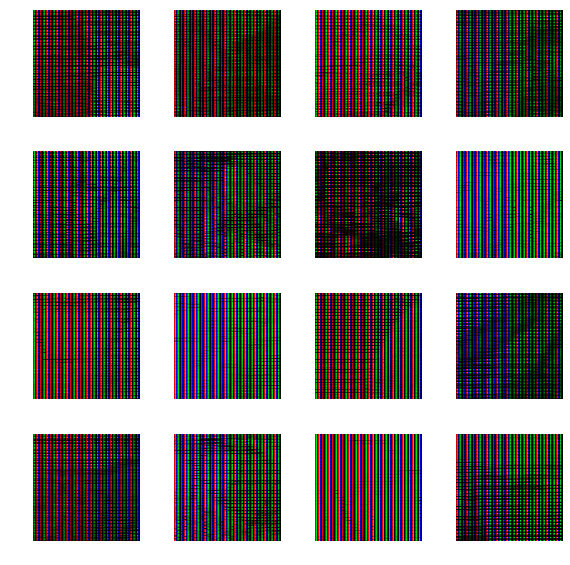

Epoch: 56	 Discriminator loss: 0.2332	 Generator loss: 3.8396
Epoch: 57	 Discriminator loss: 0.3851	 Generator loss: 2.2724
Epoch: 58	 Discriminator loss: 0.3568	 Generator loss: 2.2456
Epoch: 59	 Discriminator loss: 0.2033	 Generator loss: 2.7545
Epoch: 60	 Discriminator loss: 0.3164	 Generator loss: 3.7240


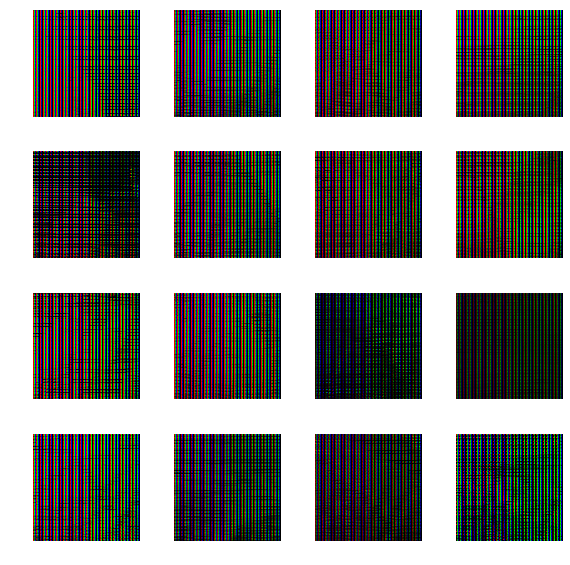

Epoch: 61	 Discriminator loss: 0.5416	 Generator loss: 3.2060
Epoch: 62	 Discriminator loss: 0.7405	 Generator loss: 1.7242
Epoch: 63	 Discriminator loss: 0.5933	 Generator loss: 2.3291
Epoch: 64	 Discriminator loss: 0.2053	 Generator loss: 4.7868
Epoch: 65	 Discriminator loss: 0.1586	 Generator loss: 2.8952


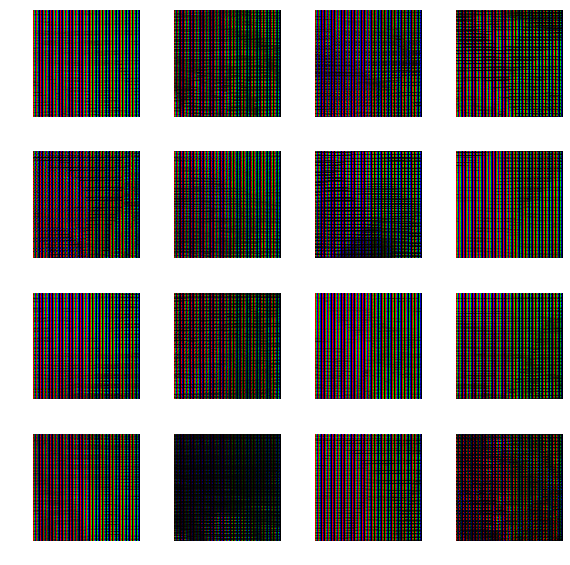

Epoch: 66	 Discriminator loss: 0.3065	 Generator loss: 5.7427
Epoch: 67	 Discriminator loss: 0.2146	 Generator loss: 5.8154
Epoch: 68	 Discriminator loss: 0.4637	 Generator loss: 4.7572
Epoch: 69	 Discriminator loss: 0.3274	 Generator loss: 5.6076
Epoch: 70	 Discriminator loss: 0.1808	 Generator loss: 3.3895


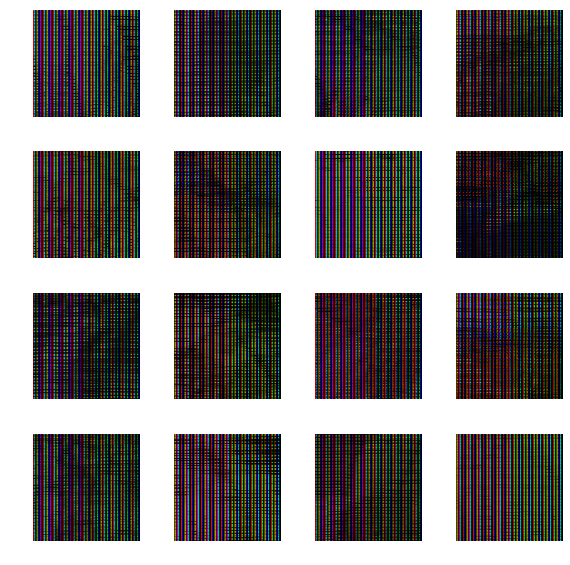

Epoch: 71	 Discriminator loss: 2.1170	 Generator loss: 0.4940
Epoch: 72	 Discriminator loss: 1.6564	 Generator loss: 8.5252
Epoch: 73	 Discriminator loss: 0.3939	 Generator loss: 5.0762
Epoch: 74	 Discriminator loss: 0.1404	 Generator loss: 4.2459
Epoch: 75	 Discriminator loss: 0.1608	 Generator loss: 4.5725


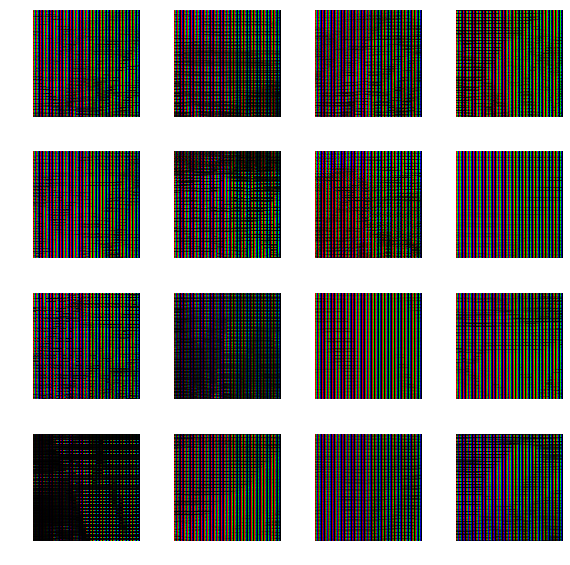

Epoch: 76	 Discriminator loss: 0.3866	 Generator loss: 5.8711
Epoch: 77	 Discriminator loss: 0.3363	 Generator loss: 4.1347
Epoch: 78	 Discriminator loss: 0.1150	 Generator loss: 3.8782
Epoch: 79	 Discriminator loss: 0.3425	 Generator loss: 5.6505
Epoch: 80	 Discriminator loss: 0.1367	 Generator loss: 6.0661


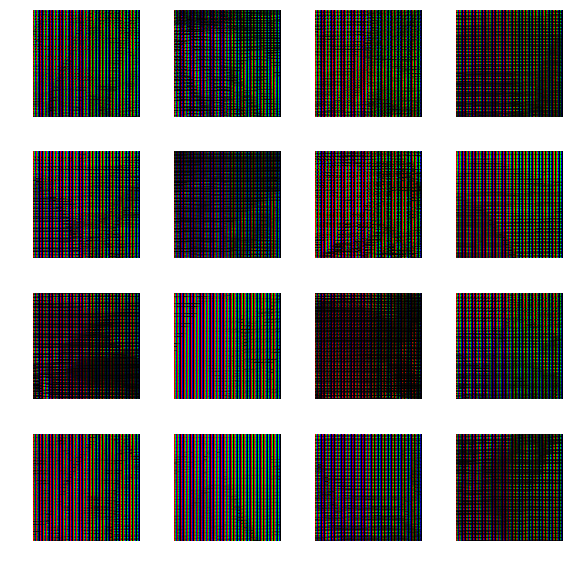

Epoch: 81	 Discriminator loss: 0.3197	 Generator loss: 5.1671
Epoch: 82	 Discriminator loss: 0.5410	 Generator loss: 5.3189
Epoch: 83	 Discriminator loss: 0.2650	 Generator loss: 6.9828
Epoch: 84	 Discriminator loss: 0.1687	 Generator loss: 3.7611
Epoch: 85	 Discriminator loss: 0.2324	 Generator loss: 5.4354


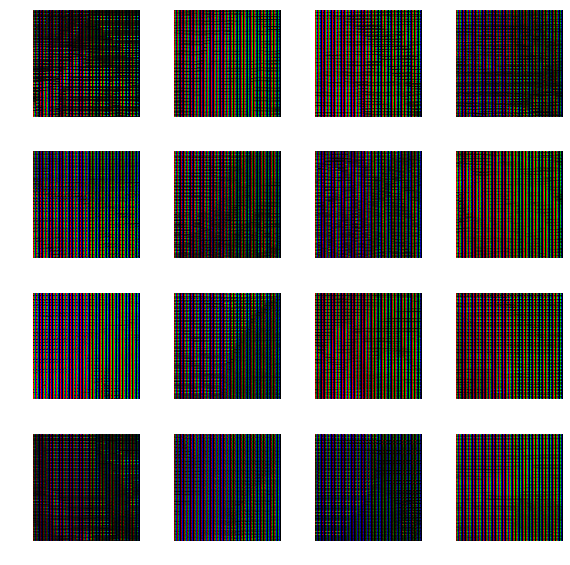

Epoch: 86	 Discriminator loss: 0.0489	 Generator loss: 3.9318
Epoch: 87	 Discriminator loss: 0.1132	 Generator loss: 3.8115
Epoch: 88	 Discriminator loss: 0.1341	 Generator loss: 3.8693
Epoch: 89	 Discriminator loss: 0.1501	 Generator loss: 4.2460
Epoch: 90	 Discriminator loss: 0.1795	 Generator loss: 3.4654


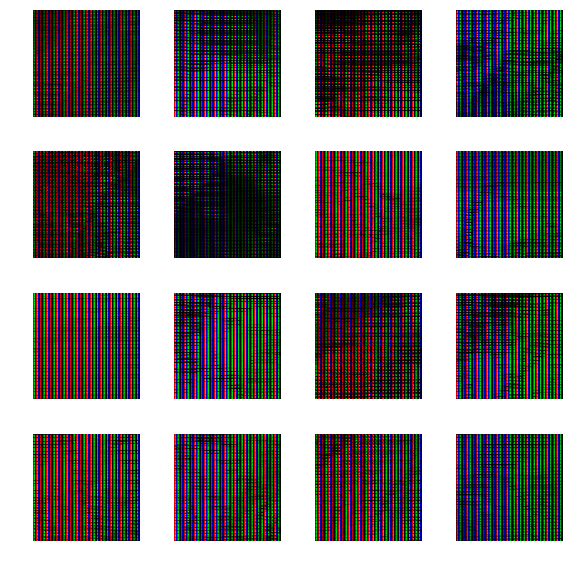

Epoch: 91	 Discriminator loss: 0.1331	 Generator loss: 5.4311
Epoch: 92	 Discriminator loss: 0.1874	 Generator loss: 5.9560
Epoch: 93	 Discriminator loss: 0.2668	 Generator loss: 6.1706


KeyboardInterrupt: 

In [22]:
BATCH_SIZE = 16
train(EPOCHS, batch_size=BATCH_SIZE)